In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import copy

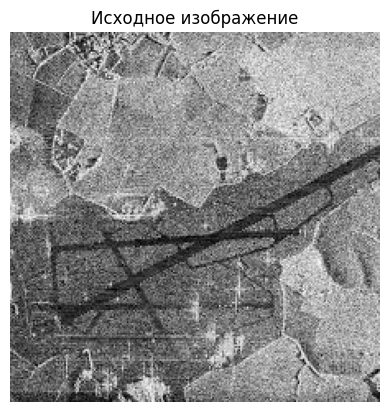

In [2]:
# Загрука изображения
image_path = 'sar_3.jpg'
image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image_gray is None:
    raise FileNotFoundError(f"Изображение {image_path} не найдено!")

plt.imshow(image_gray, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')
plt.show()